The goal here is to compare two specific runs (mostly from historical and SSP) and plot their risk ratios

Import modules


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import matplotlib
from matplotlib.ticker import MaxNLocator,FormatStrFormatter
import pickle
from glob import glob
import sys  
import matplotlib.gridspec as gridspec
from scipy.stats import linregress
from dateutil.relativedelta import relativedelta
import itertools
import pickle
from cartopy.util import add_cyclic_point


from scipy.ndimage import label,find_objects
import scipy.ndimage as ndimage
from matplotlib.colors import LinearSegmentedColormap

import datetime as dt
import cartopy
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import xarray as xr
from multiprocessing import Pool,current_process  ### module for parallel programming
from itertools import repeat


%matplotlib inline

### Read inputs ###

In [3]:
! ls -altr /home/fiaz/cluster_analysis/*.out

-rw-r--r--. 1 fiaz fiaz  660497829 Feb 19 14:02 /home/fiaz/cluster_analysis/clusters_output_CNRM-CM6-1_200201_201412.out
-rw-r--r--. 1 fiaz fiaz  492379397 Feb 19 14:13 /home/fiaz/cluster_analysis/clusters_output_SSP585_CNRM-CM6-1_209101_210012.out
-rw-r--r--. 1 fiaz fiaz 2878428741 Feb 19 15:39 /home/fiaz/cluster_analysis/clusters_output_TRMM3B42_200201_201412.out
-rw-r--r--. 1 fiaz fiaz  437862277 Mar  4 09:32 /home/fiaz/cluster_analysis/clusters_output_KACE-1-0-G_199001_199912.out
-rw-r--r--. 1 fiaz fiaz  245154949 Mar  5 15:11 /home/fiaz/cluster_analysis/clusters_output_SSP585_@KACE-1-0-G_209101_210012.out
-rw-r--r--. 1 fiaz fiaz 1204828901 Mar 12 09:09 /home/fiaz/cluster_analysis/clusters_output_BCC-CSM2-MR_200201_201412.out
-rw-r--r--. 1 fiaz fiaz  884209829 Mar 12 09:19 /home/fiaz/cluster_analysis/clusters_output_SSP585_BCC-CSM2-MR_209101_210012.out
-rw-r--r--. 1 fiaz fiaz  508041893 Apr 28 10:19 /home/fiaz/cluster_analysis/clusters_output_CNRM-CM6-1_200501_201412.out


In [4]:
## replace directories with the folder where the .out files are stored for the 
## HIST and SSP models
dirc_ssp="/home/fiaz/cluster_analysis/"
dirc_hist="/home/fiaz/cluster_analysis/"

obs_name=['TRMM3B42_200201_201412']
model_names_HIST=['BCC-CSM2-MR_200201_201412','CNRM-CM6-1_200201_201412','KACE-1-0-G_199001_199912']
model_names_SSP=['BCC-CSM2-MR_209101_210012','CNRM-CM6-1_209101_210012','@KACE-1-0-G_209101_210012']
model_names_SSP=['SSP585_'+i for i in model_names_SSP] ## adding the SSP585 prefix to all models 



def read_files (dirc,namelist,cluster_dict):
    for i in namelist:
        file_path=dirc+'clusters_output_'+i+'.out'
        print('Reading '+file_path)
        file_name=glob(file_path)[0]
        with open(file_name, 'rb') as handle:
            cluster_dict[i] = pickle.load(handle)
    

### read all the info into the cluster_dict ###
dict_HIST={}
dict_SSP={}
read_files(dirc_hist,model_names_HIST,dict_HIST)
read_files(dirc_ssp,model_names_SSP,dict_SSP)


Reading /home/fiaz/cluster_analysis/clusters_output_BCC-CSM2-MR_200201_201412.out
Reading /home/fiaz/cluster_analysis/clusters_output_CNRM-CM6-1_200201_201412.out
Reading /home/fiaz/cluster_analysis/clusters_output_KACE-1-0-G_199001_199912.out
Reading /home/fiaz/cluster_analysis/clusters_output_SSP585_BCC-CSM2-MR_209101_210012.out
Reading /home/fiaz/cluster_analysis/clusters_output_SSP585_CNRM-CM6-1_209101_210012.out
Reading /home/fiaz/cluster_analysis/clusters_output_SSP585_@KACE-1-0-G_209101_210012.out


### Specify files to compare ###

In [5]:
### get list of files to compare ###
files_comp=[dict_HIST,dict_SSP]

### Set thresholds to compare ###
#### default is set to 1 mm/hr; change to other thresholds to play around

In [6]:
### get list of precip. thresholds ###
pthresh_list_full=list(dict_SSP[model_names_SSP[0]]['hist_pcp_sizes'].keys())
pthresh_ix=pthresh_list_full.index(1.0)  ### change to 1.0, 0.75, 0.50, 0.25
pthresh_list=pthresh_list_full[pthresh_ix:pthresh_ix+1]

In [7]:
### Compute risk ratios ###

nthresh=25

def extract_grid_info(dict_input):
    
    sizes=dict_input['sizes']
    sz=(sizes[:-1]+sizes[1:])*0.5
    sz_diff=np.diff(sizes)   
    
    precip_cluster_power_scale=dict_input['precip_cluster_power_scale']
    pcp_clus_pow_bins=sizes*precip_cluster_power_scale*0.5
    pcp_clust_sz=(pcp_clus_pow_bins[:-1]+pcp_clus_pow_bins[1:])*0.5
    
    pcp_clust_sz_diff=np.diff(pcp_clus_pow_bins)

    power_scale=dict_input['precip_cluster_power_scale']
    pixels_to_area=dict_input['pixels_to_area']

    return sz,pcp_clust_sz,sz_diff,pcp_clust_sz_diff,power_scale,pixels_to_area


def compute_risk_ratios(dict_HIST,dict_SSP,pthresh):
    
    hist_pcp_sizes={}
    hist_pcp_clust_pow={}
    
    hist_pcp_clust_size_pdf={}
    hist_pcp_clust_pow_pdf={}
    
    pcp_sizes={}
    pcp_power={}
    
    sz={}
    pcp_clust_sz={}
    sz_diff={}
    pcp_clust_sz_diff={}
    power_scale={}
    pixels_to_area={}
    am={}
    cm={}
    sz_scaled={}
    
    ### Read power and size
    
    hist_pcp_sizes['HIST']=dict_HIST['hist_pcp_sizes'][pthresh]
    hist_pcp_sizes['SSP']=dict_SSP['hist_pcp_sizes'][pthresh]
    
    hist_pcp_clust_pow['HIST']=dict_HIST['hist_pcp_clust_pow'][pthresh]
    hist_pcp_clust_pow['SSP']=dict_SSP['hist_pcp_clust_pow'][pthresh]
    
    pcp_sizes['HIST']=dict_HIST['pcp_sizes'][pthresh]
    pcp_sizes['SSP']=dict_SSP['pcp_sizes'][pthresh]

    pcp_power['HIST']=dict_HIST['pcp_power'][pthresh]
    pcp_power['SSP']=dict_SSP['pcp_power'][pthresh]
    
    sizes=dict_HIST['sizes']
#     power_scale=dict_HIST['precip_cluster_power_scale']

    ### Get grid information
        
    sz['HIST'],pcp_clust_sz['HIST'],sz_diff['HIST'],pcp_clust_sz_diff['HIST'],power_scale['HIST'], pixels_to_area['HIST']=extract_grid_info(dict_HIST)

    sz['SSP'],pcp_clust_sz['SSP'],sz_diff['SSP'],pcp_clust_sz_diff['SSP'], power_scale['SSP'], pixels_to_area['SSP']=extract_grid_info(dict_SSP)
    
    
    for key in hist_pcp_sizes.keys():
        
        
        hist_pcp_sizes[key]=np.histogram(pcp_sizes[key],
                                bins=sizes)[0]
    
        hist_pcp_clust_pow[key]=np.histogram(pcp_power[key],
                                    bins=sizes*power_scale[key])[0]

        hist_pcp_clust_size_pdf[key]=hist_pcp_sizes[key]/(sz_diff[key]*hist_pcp_sizes[key].sum())
        hist_pcp_clust_size_pdf[key][hist_pcp_sizes[key]<nthresh]=np.nan
        
        hist_pcp_clust_pow_pdf[key]=hist_pcp_clust_pow[key]/(pcp_clust_sz_diff[key]*hist_pcp_clust_pow[key].sum())
        hist_pcp_clust_pow_pdf[key][hist_pcp_clust_pow[key]==0]=np.nan
        
        am[key]=np.mean(pcp_sizes[key]**2)*pixels_to_area[key]/np.mean(pcp_sizes[key])
        cm[key]=np.mean(pcp_power[key]**2)/np.mean(pcp_power[key])
        sz_scaled[key]=sz[key]*pixels_to_area[key]

    risk_ratio_size=hist_pcp_clust_size_pdf['SSP']/hist_pcp_clust_size_pdf['HIST']
    risk_ratio_power=hist_pcp_clust_pow['SSP']/hist_pcp_clust_pow['HIST']
        
    return risk_ratio_size, risk_ratio_power, sz_scaled, pcp_clust_sz



In [8]:
### Compute risk ratios ###

nthresh=25

def extract_grid_info(dict_input):
    
    sizes=dict_input['sizes']
    sz=(sizes[:-1]+sizes[1:])*0.5
    sz_diff=np.diff(sizes)   
    
    precip_cluster_power_scale=dict_input['precip_cluster_power_scale']
    pcp_clus_pow_bins=sizes*precip_cluster_power_scale*0.5
    pcp_clust_sz=(pcp_clus_pow_bins[:-1]+pcp_clus_pow_bins[1:])*0.5
    
    pcp_clust_sz_diff=np.diff(pcp_clus_pow_bins)

    power_scale=dict_input['precip_cluster_power_scale']
    pixels_to_area=dict_input['pixels_to_area']

    return sz,pcp_clust_sz,sz_diff,pcp_clust_sz_diff,power_scale,pixels_to_area


def norm_pdf(hist,diff,thresh):
    hist_norm=hist/(hist.sum()*thresh)
    hist_norm[hist<thresh]=np.nan
    return hist_norm


def convert_hist_to_risk_ratios(hist_sizes,hist_power,sz_diffs,pow_diffs,nthresh):

    hist_size1,hist_size2=hist_sizes
    hist_pow1,hist_pow2=hist_power

    sz_diff1,sz_diff2=sz_diffs
    pow_diff1,pow_diff2=pow_diffs
    
    hist_size1_norm=norm_pdf(hist_size1,sz_diff1,nthresh)
    hist_size2_norm=norm_pdf(hist_size2,sz_diff1,nthresh)

    hist_pow1_norm=norm_pdf(hist_pow1,pow_diff1,nthresh)
    hist_pow2_norm=norm_pdf(hist_pow2,pow_diff2,nthresh)

    risk_ratio_size=hist_size2_norm/hist_size1_norm
    risk_ratio_pow=hist_pow2_norm/hist_pow1_norm
    return risk_ratio_size,risk_ratio_pow

def extract_hist_from_dict(dict_input, key, pcp_sizes, pcp_power, hist_pcp_sizes,hist_pcp_clust_pow,
                               sz_diff, pcp_clust_sz_diff, sizes, sz_scaled, power_scale, pcp_clust_sz, pthresh):
    
    hist_pcp_sizes[key]=dict_input['hist_pcp_sizes'][pthresh]
    hist_pcp_clust_pow[key]=dict_input['hist_pcp_clust_pow'][pthresh]
    pcp_sizes[key]=dict_input['pcp_sizes'][pthresh]
    pcp_power[key]=dict_input['pcp_power'][pthresh]
    sizes[key]=dict_input['sizes']
    power_scale[key]=dict_input['precip_cluster_power_scale']

    sz, pcp_clust_sz[key], sz_diff[key], pcp_clust_sz_diff[key], power_scale, pixels_to_area=extract_grid_info(dict_input)
    sz_scaled[key]=sz*pixels_to_area
    
    return None

def run_bootstrap(n,sizes,power_scale,args):
    np.random.seed(n)
    hist_pcp_power_bootstrap={}
    hist_pcp_sizes_bootstrap={}

    keys=['HIST','SSP']

    for key in keys:
        hist_pcp_power_bootstrap[key]={}
        hist_pcp_sizes_bootstrap[key]={}

        pcp_sizes_random=np.random.choice(pcp_sizes[key],size=pcp_sizes[key].size)
        pcp_power_random=np.random.choice(pcp_power[key],size=pcp_power[key].size)

        hist_pcp_sizes_bootstrap[key]=np.histogram(pcp_sizes_random,
                    bins=sizes[key])[0]

        hist_pcp_power_bootstrap[key]=np.histogram(pcp_power_random,
                                    bins=sizes[key]*power_scale[key]*0.5)[0]

    
    hist_sizes,hist_power,sz_diffs,pow_diffs,nthresh=args

    hist_sizes=[hist_pcp_sizes_bootstrap['HIST'],hist_pcp_sizes_bootstrap['SSP']]
    hist_power=[hist_pcp_power_bootstrap['HIST'],hist_pcp_power_bootstrap['SSP']]
    risk_ratio_size_bootstrap,risk_ratio_power_bootstrap=convert_hist_to_risk_ratios(hist_sizes,hist_power,sz_diffs,
                                                         pow_diffs,nthresh)
    
    return risk_ratio_size_bootstrap,risk_ratio_power_bootstrap


def compute_risk_ratios_bootstrap(dict_HIST,dict_SSP,pthresh,nproc,nbootstrap):
    
    hist_pcp_sizes={}
    hist_pcp_clust_pow={}
    sz_diff={}
    pcp_clust_sz_diff={}
    sz_scaled={}
    pcp_clust_sz={}
    pcp_sizes={}
    pcp_power={}
    sizes={}
    power_scale={}

    extract_hist_from_dict(dict_HIST,'HIST', pcp_sizes, pcp_power, hist_pcp_sizes,hist_pcp_clust_pow,
                               sz_diff, pcp_clust_sz_diff, sizes, sz_scaled, power_scale, pcp_clust_sz, pthresh)

    extract_hist_from_dict(dict_SSP,'SSP', pcp_sizes, pcp_power, hist_pcp_sizes,hist_pcp_clust_pow,
                                   sz_diff, pcp_clust_sz_diff, sizes, sz_scaled, power_scale, pcp_clust_sz, pthresh)

    hist_sizes=[hist_pcp_sizes['HIST'],hist_pcp_sizes['SSP']]
    hist_power=[hist_pcp_clust_pow['HIST'],hist_pcp_clust_pow['SSP']]
    sz_diffs=[sz_diff['HIST'],sz_diff['SSP']]
    pow_diffs=[pcp_clust_sz_diff['HIST'],pcp_clust_sz_diff['SSP']]
    
    risk_ratio_size,risk_ratio_power=convert_hist_to_risk_ratios(hist_sizes,hist_power,sz_diffs,
                                                                 pow_diffs,nthresh)
    args=[hist_sizes,hist_power,sz_diffs,pow_diffs,nthresh]


    return risk_ratio_size, risk_ratio_power, pcp_sizes, pcp_power, sz_scaled, pcp_clust_sz, sizes, power_scale, sz_diffs, pow_diffs, args




In [9]:
size_pdf={}
power_pdf={}
am={}
cm={}
risk_ratio_size={}
risk_ratio_power={}
size_spread_bootstrap={}
size_mean_bootstrap={}

pow_spread_bootstrap={}
pow_mean_bootstrap={}

sz_scaled={}
pcp_clust_sz={}

nproc=50
nbootstrap=1000

### fix seed for pseudo-random numbers ###
np.random.seed(0)

for key_hist,key_ssp in zip(dict_HIST.keys(),dict_SSP.keys()):
    print(key_hist,key_ssp)
    ret=compute_risk_ratios_bootstrap(dict_HIST[key_hist],dict_SSP[key_ssp],pthresh_list[0],nproc,nbootstrap)
    risk_ratio_size[key_hist], risk_ratio_power[key_hist], pcp_sizes, pcp_power, sz_scaled[key_hist], pcp_clust_sz[key_hist], sizes, power_scale, sz_diffs, pow_diffs, args=ret
    
    pool = Pool(processes=nproc)
    pooled_list = pool.starmap(run_bootstrap,zip(range(nbootstrap),repeat(sizes),repeat(power_scale),repeat(args)))
    
    risk_ratio_size_bootstrap=np.asarray([pooled_list[i][0] for i in range(len(pooled_list))])
    risk_ratio_power_bootstrap=np.asarray([pooled_list[i][1] for i in range(len(pooled_list))])

        
    size_spread_bootstrap[key_hist]=[np.nanpercentile(risk_ratio_size_bootstrap,5,axis=0),
                           np.nanpercentile(risk_ratio_size_bootstrap,95,axis=0)]
    size_mean_bootstrap[key_hist]=np.nanmean(risk_ratio_size_bootstrap,axis=0)
    
    pow_spread_bootstrap[key_hist]=[np.nanpercentile(risk_ratio_power_bootstrap,5,axis=0),
                       np.nanpercentile(risk_ratio_power_bootstrap,95,axis=0)]
    pow_mean_bootstrap[key_hist]=np.nanmean(risk_ratio_power_bootstrap,axis=0)





BCC-CSM2-MR_200201_201412 SSP585_BCC-CSM2-MR_209101_210012
CNRM-CM6-1_200201_201412 SSP585_CNRM-CM6-1_209101_210012


/home/fiaz/anaconda3/envs/aos112/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
<ipython-input-9-17de8951f2b9>:36: RuntimeWarning: Mean of empty slice
  size_mean_bootstrap[key_hist]=np.nanmean(risk_ratio_size_bootstrap,axis=0)
<ipython-input-9-17de8951f2b9>:40: RuntimeWarning: Mean of empty slice
  pow_mean_bootstrap[key_hist]=np.nanmean(risk_ratio_power_bootstrap,axis=0)


KACE-1-0-G_199001_199912 SSP585_@KACE-1-0-G_209101_210012


### Plot risk ratios ###

In [10]:
len(sz_scaled.keys())

3

In [11]:
cmap=plt.get_cmap('Dark2',len(sz_scaled.keys()))
model_colors={}
for key,i in zip(sz_scaled.keys(), np.linspace(0,1.0,len(sz_scaled.keys()))):
    print(i)
    model_colors[key]=cmap(i)

0.0
0.5
1.0


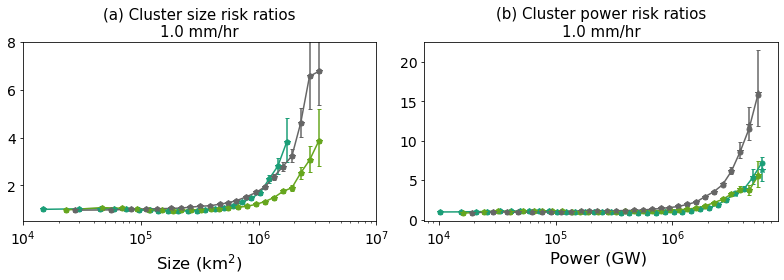

In [12]:
### Some user defined parameters ###
nthresh=25 #Discard bins with fewer than nthresh samples
istrt_sz,iend_sz=3.0,5.0 ## the power law range for size (10^3 to 10^5)
istrt_pow,iend_pow=4.0,5.5 ### set a ballpark range for the power law, so the straight line fit is over that range

title_fontsize=15
xlabel_fontsize=16.5
ylabel_fontsize=16.5

## x and yaxis limits for cluster size
xlim_sz=[1e4,1e7] 
ylim_sz=[0.5,8] ##

## x and yaxis limits for cluster power
xlim_pow=[1e3,2.5e8] ##
ylim_pow=[0.5,35] ##

## threshold legend font size
leg_fontsize=12.5

## moment ratio * power law slope font size
leg1_fontsize=13.5

## ticklabel font size
ticks_fontsize=14

### set the plot specs:
### size
fig=plt.figure(figsize=(11,4.))
## grid: 1 row , 2 colum plot
gs = gridspec.GridSpec(1, 2)
## assign separate name for each axis
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])

### set four colors here for the different precip. thresholds ###
c=['black','red']

### create empty dictionaries to hold the legends 
ln1={}
ln2={}

### positions for some of the text on the plot
posy=[ 0.65,  .85,.65, 0.725, .8, .875 ]
posx=[.65,  0.65, .35, .4, .4 ]
iendt=[5, 4.5, 4, 3.5, 3.0, 3.0, 3.0, 3.0]

ax=ax1
ln1={}
for key in sz_scaled.keys():
    ln1[key]=ax.semilogx(sz_scaled[key]['HIST'],risk_ratio_size[key],marker='o',c=model_colors[key],markersize=5)
#     ln1[key]=ax.semilogx(sz_scaled[key]['HIST'],risk_ratio_size[key],marker='*',c=model_colors[key],markersize=5)

    yerr=abs(size_spread_bootstrap[key]-size_mean_bootstrap[key])
    ln1[key]=ax.errorbar(sz_scaled[key]['HIST'], risk_ratio_size[key], yerr=yerr, 
                       fmt='*',c=model_colors[key], capsize=2.25)
    
ax.set_title("(a) Cluster size risk ratios\n%.1f mm/hr"%(pthresh_list[0]),fontsize=title_fontsize)
ax.set_xlabel("Size ($\mathrm{km^2}$) ",fontsize=xlabel_fontsize)
# ax.set_ylabel("Risk Ratio",fontsize=ylabel_fontsize)
ax.set_xlim(xlim_sz)
ax.set_ylim(ylim_sz)
# ax.yaxis.set_major_locator(plt.FixedLocator([1e0, 1e-2, 1e-4, 1e-6, 1e-8, 1e-10]))
ax.tick_params(which='both', labelsize=ticks_fontsize)


ax=ax2
for key in sz_scaled.keys():
    ax.semilogx(pcp_clust_sz[key]['HIST'],risk_ratio_power[key],marker='o',c=model_colors[key],markersize=5)
#     yerr=abs(pow_spread_bootstrap[key]-risk_ratio_size[key])

    yerr=abs(pow_spread_bootstrap[key]-pow_mean_bootstrap[key])

    ax.errorbar(pcp_clust_sz[key]['HIST'], pow_mean_bootstrap[key], yerr=yerr, 
                       fmt='*',c=model_colors[key], capsize=2.25)


ax.set_title("(b) Cluster power risk ratios\n%.1f mm/hr"%(pthresh_list[0]),fontsize=title_fontsize)

ax.set_xlabel("Power (GW) ",fontsize=xlabel_fontsize)
# ax.set_ylabel("Risk Ratio",fontsize=ylabel_fontsize)
# ax.set_xlim(xlim_pow)
# ax.set_ylim(ylim_pow)
# ax.yaxis.set_major_locator(plt.FixedLocator([1e0, 1e-2, 1e-4, 1e-6, 1e-8, 1e-10]))
ax.tick_params(which='both', labelsize=ticks_fontsize)

# plt.suptitle('Risk ratios',fontsize=16)
plt.tight_layout()
SAVE_FIG=False
if SAVE_FIG:
    dirp='./' ## current location, but change as needed
    save_fig_name=dirp+"risk_ratios_%.2f_%s"%(pthresh_list[0],model_list[model_index])+".pdf"

    plt.savefig(save_fig_name,format='pdf',dpi=150,bbox_inches='tight')



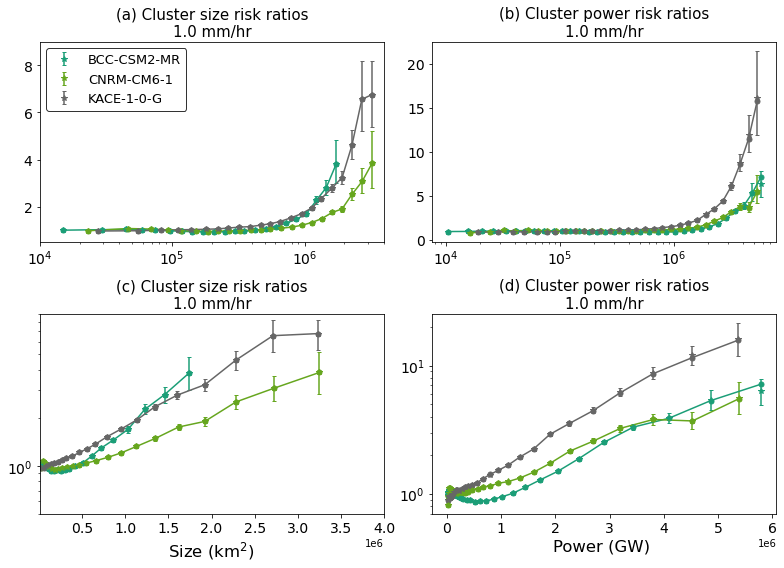

In [14]:
### Some user defined parameters ###
nthresh=25 #Discard bins with fewer than nthresh samples
istrt_sz,iend_sz=3.0,5.0 ## the power law range for size (10^3 to 10^5)
istrt_pow,iend_pow=4.0,5.5 ### set a ballpark range for the power law, so the straight line fit is over that range

title_fontsize=15
xlabel_fontsize=16.5
ylabel_fontsize=16.5

## x and yaxis limits for cluster size
xlim_sz=[1e4,4e6] 
ylim_sz=[0.5,9] ##

## x and yaxis limits for cluster power
xlim_pow=[1e3,2.5e8] ##
ylim_pow=[0.5,35] ##

## threshold legend font size
leg_fontsize=12.5

## moment ratio * power law slope font size
leg1_fontsize=13.5

## ticklabel font size
ticks_fontsize=14

### set the plot specs:
### size
fig=plt.figure(figsize=(11,8.))
## grid: 1 row , 2 colum plot
gs = gridspec.GridSpec(2, 2)
## assign separate name for each axis
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])

### set four colors here for the different precip. thresholds ###
c=['black','red']

### create empty dictionaries to hold the legends 
ln1={}
ln2={}

### positions for some of the text on the plot
posy=[ 0.65,  .85,.65, 0.725, .8, .875 ]
posx=[.65,  0.65, .35, .4, .4 ]
iendt=[5, 4.5, 4, 3.5, 3.0, 3.0, 3.0, 3.0]

ax=ax1
ln1={}
for key in sz_scaled.keys():
    ln1[key]=ax.semilogx(sz_scaled[key]['HIST'],risk_ratio_size[key],marker='o',c=model_colors[key],markersize=5)
    yerr=abs(size_spread_bootstrap[key]-size_mean_bootstrap[key])
    ln1[key]=ax.errorbar(sz_scaled[key]['HIST'], risk_ratio_size[key], yerr=yerr, 
                       fmt='*',c=model_colors[key], capsize=2.25)
    
ax.set_title("(a) Cluster size risk ratios\n%.1f mm/hr"%(pthresh_list[0]),fontsize=title_fontsize)
ax.set_xlim(xlim_sz)
ax.set_ylim(ylim_sz)
ax.tick_params(which='both', labelsize=ticks_fontsize)
leg_labels=[i.split('_')[0] for i in list(ln1.keys())]

leg=ax.legend(ln1.values(),leg_labels,fontsize=13)
frame=leg.get_frame()
frame.set_edgecolor('black')

ax=ax2
for key in sz_scaled.keys():
    ax.semilogx(pcp_clust_sz[key]['HIST'],risk_ratio_power[key],marker='o',c=model_colors[key],markersize=5)

    yerr=abs(pow_spread_bootstrap[key]-pow_mean_bootstrap[key])

    ax.errorbar(pcp_clust_sz[key]['HIST'], pow_mean_bootstrap[key], yerr=yerr, 
                       fmt='*',c=model_colors[key], capsize=2.25)


ax.set_title("(b) Cluster power risk ratios\n%.1f mm/hr"%(pthresh_list[0]),fontsize=title_fontsize)

ax.tick_params(which='both', labelsize=ticks_fontsize)


ax1 = plt.subplot(gs[1, 0])
ax2 = plt.subplot(gs[1, 1])



ax=ax1
ln1={}
for key in sz_scaled.keys():
    ln1[key]=ax.semilogy(sz_scaled[key]['HIST'],risk_ratio_size[key],marker='o',c=model_colors[key],markersize=5)

    yerr=abs(size_spread_bootstrap[key]-size_mean_bootstrap[key])
    ln1[key]=ax.errorbar(sz_scaled[key]['HIST'], risk_ratio_size[key], yerr=yerr, 
                       fmt='*',c=model_colors[key], capsize=2.25)
    
ax.set_title("(c) Cluster size risk ratios\n%.1f mm/hr"%(pthresh_list[0]),fontsize=title_fontsize)
ax.set_xlabel("Size ($\mathrm{km^2}$) ",fontsize=xlabel_fontsize)
ax.set_xlim(xlim_sz)
ax.set_ylim(ylim_sz)
ax.tick_params(which='both', labelsize=ticks_fontsize)


ax=ax2
for key in sz_scaled.keys():
    ax.semilogy(pcp_clust_sz[key]['HIST'],risk_ratio_power[key],marker='o',c=model_colors[key],markersize=5)

    yerr=abs(pow_spread_bootstrap[key]-pow_mean_bootstrap[key])

    ax.errorbar(pcp_clust_sz[key]['HIST'], pow_mean_bootstrap[key], yerr=yerr, 
                       fmt='*',c=model_colors[key], capsize=2.25)


ax.set_title("(d) Cluster power risk ratios\n%.1f mm/hr"%(pthresh_list[0]),fontsize=title_fontsize)

ax.set_xlabel("Power (GW) ",fontsize=xlabel_fontsize)
ax.tick_params(which='both', labelsize=ticks_fontsize)
# ax.set_xlim(xlim_pow)
plt.tight_layout()
SAVE_FIG=False
if SAVE_FIG:
    dirp='./' ## current location, but change as needed
    save_fig_name=dirp+"risk_ratios_CMIP6.pdf"

    plt.savefig(save_fig_name,format='pdf',dpi=150,bbox_inches='tight')




In [23]:
dirp

'./'